# Analysis

# 0. Loading necessary libraries. 

In [1]:
import rasterio
import keplergl
import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import matplotlib
import mapclassify
import json
import base64
import IPython
import plotly.express as px


plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (6, 6), 'axes.edgecolor': '0.2'})

# 1. BC Forest data

In [2]:
# Loading date
forest_data = gpd.read_file("data/FADM_PROV_FOREST")
forest_data = forest_data.to_crs("EPSG:4326")    # I'm converting to a different coordinate reference system
forest_data.head()

,FEATURE_ID,PRV_FRST_D,PRV_FRST_N,MP_BLCK_ID,DTA_SRC_CD,DT_SRC_CDN,CPTR_MTHDD,CPTR_MTHDN,ACCRCY_CD,EFF_DATE,...,COMMENTS,FEATURE_CD,WHO_UPDTD,WHEN_UPDTD,FC_SKEY,OBJ_V_SKEY,OBJECTID,AREA_SQM,FEAT_LEN,geometry
0,2084,114,Kitimat,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,102809.0,1.823465e+06,7.279941e+03,"POLYGON ((-128.48427 54.30898, -128.48444 54.3..."
1,2085,84,Skeena,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,102810.0,4.656531e+09,1.207955e+06,"MULTIPOLYGON (((-128.70612 54.63438, -128.6936..."
2,2086,114,Kitimat,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,102811.0,7.808455e+06,1.645594e+04,"MULTIPOLYGON (((-128.54663 54.35278, -128.5454..."
3,2087,37,Bell-Irving,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,102812.0,1.070620e+10,9.848731e+05,"POLYGON ((-130.31004 56.38185, -130.31003 56.3..."
4,2088,112,Hecate,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,0.0,102813.0,6.832526e+08,2.100182e+05,"POLYGON ((-130.00979 56.17126, -130.00966 56.1..."


In [3]:
forest_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FEATURE_ID  296 non-null    object  
 1   PRV_FRST_D  296 non-null    object  
 2   PRV_FRST_N  296 non-null    object  
 3   MP_BLCK_ID  277 non-null    object  
 4   DTA_SRC_CD  0 non-null      float64 
 5   DT_SRC_CDN  0 non-null      float64 
 6   CPTR_MTHDD  0 non-null      float64 
 7   CPTR_MTHDN  0 non-null      float64 
 8   ACCRCY_CD   0 non-null      float64 
 9   EFF_DATE    14 non-null     object  
 10  RETRMNT_DT  21 non-null     object  
 11  COMMENTS    0 non-null      float64 
 12  FEATURE_CD  0 non-null      float64 
 13  WHO_UPDTD   0 non-null      float64 
 14  WHEN_UPDTD  0 non-null      float64 
 15  FC_SKEY     296 non-null    float64 
 16  OBJ_V_SKEY  296 non-null    float64 
 17  OBJECTID    296 non-null    float64 
 18  AREA_SQM    296 non-null    float64 
 19  

In [4]:
# Drop columns with all NaN values
forest_data_cleaned = forest_data.dropna(axis=1, how='all')

# Drop the specified columns
columns_to_drop = ['MP_BLCK_ID', 'EFF_DATE', 'RETRMNT_DT', 'FC_SKEY', 'OBJ_V_SKEY']
forest_data_cleaned = forest_data_cleaned.drop(columns=columns_to_drop)

# Rename the columns in forest_data_cleaned
forest_data_cleaned = forest_data_cleaned.rename(columns={
    'PRV_FRST_N': 'Forest_Name',
    'AREA_SQM': 'Forest_Area',
    'FEAT_LEN': 'Forest_Length'
})

forest_data_cleaned.head()

,FEATURE_ID,PRV_FRST_D,Forest_Name,OBJECTID,Forest_Area,Forest_Length,geometry
0,2084,114,Kitimat,102809.0,1.823465e+06,7.279941e+03,"POLYGON ((-128.48427 54.30898, -128.48444 54.3..."
1,2085,84,Skeena,102810.0,4.656531e+09,1.207955e+06,"MULTIPOLYGON (((-128.70612 54.63438, -128.6936..."
2,2086,114,Kitimat,102811.0,7.808455e+06,1.645594e+04,"MULTIPOLYGON (((-128.54663 54.35278, -128.5454..."
3,2087,37,Bell-Irving,102812.0,1.070620e+10,9.848731e+05,"POLYGON ((-130.31004 56.38185, -130.31003 56.3..."
4,2088,112,Hecate,102813.0,6.832526e+08,2.100182e+05,"POLYGON ((-130.00979 56.17126, -130.00966 56.1..."


In [5]:
forest_data_cleaned.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FEATURE_ID     296 non-null    object  
 1   PRV_FRST_D     296 non-null    object  
 2   Forest_Name    296 non-null    object  
 3   OBJECTID       296 non-null    float64 
 4   Forest_Area    296 non-null    float64 
 5   Forest_Length  296 non-null    float64 
 6   geometry       296 non-null    geometry
dtypes: float64(3), geometry(1), object(3)
memory usage: 16.3+ KB


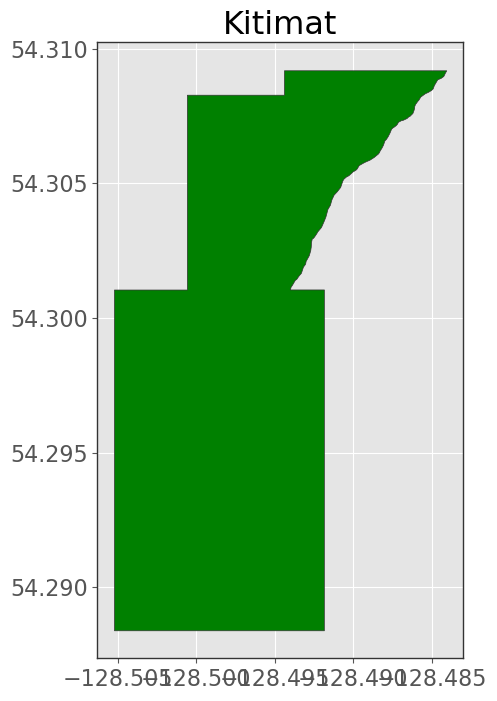

In [6]:
# Take a look at an example. The Kitimat Forest in BC. 
name = forest_data_cleaned.iloc[0]["Forest_Name"]
forest_data.iloc[[0]].plot(edgecolor="0.2", figsize=(10, 8), color = "green")
plt.title(name);

## 1.1 Basic Spatial Exploration

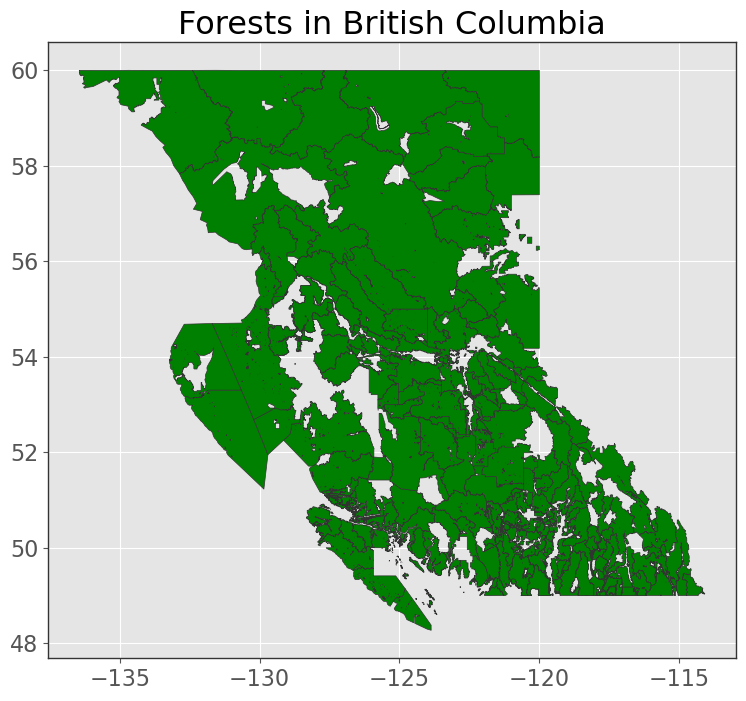

In [7]:
# Take a look at the entire forest map.
forest_data_cleaned.plot(edgecolor="0.2", figsize=(10, 8), color ="green")
plt.title("Forests in British Columbia");

## 1.2 Forest Area Analysis

In [8]:
# Aggregate forest areas by region
region_area = forest_data_cleaned.groupby('Forest_Name')['Forest_Area'].sum().sort_values(ascending=True)
region_area

Forest_Name
Surrey           1.943675e+06
Cowichan Lake    2.177505e+06
Green Timbers    2.547819e+06
Red Rock         2.246754e+07
Blue Mountain    4.473812e+07
                     ...     
Skeena           3.072651e+10
Hecate           3.101665e+10
Taku             3.458893e+10
Stikine          3.867857e+10
Finlay           6.099606e+10
Name: Forest_Area, Length: 139, dtype: float64

In [9]:
# Aggregate forest areas by region
region_area_df = region_area.reset_index()

# Create the initial bar plot figure with reversed order
bar_fig = px.bar(
    region_area_df,
    x='Forest_Area',
    y='Forest_Name',
    orientation='h',
    title='Total Forest Area by Region',
    labels={'Forest_Name': 'Forest Name', 'Forest_Area': 'Area (square meters)'}
)
bar_fig.update_layout(xaxis_title="Area (square meters)", yaxis_title="Forest Name", height=800)


## 1.3 Create a base map for visualizing the polygons

This takes a while as the polygons are very detailed. Please use the simplified dataframe below if you wish to speed up processing. 

In [10]:
# fig = px.choropleth_mapbox(
#     forest_data_cleaned, 
#     geojson=forest_data_cleaned.geometry, 
#     locations=forest_data_cleaned.index,  # Use the index to bind the polygons
#     hover_name="Forest_Name",  # Show forest name on hover
#     mapbox_style="open-street-map",
#     zoom=4,
#     center={"lat": 53.7267, "lon": -127.6476},  # Center the map over British Columbia
#     opacity=0.5,
#     color_discrete_sequence=["green"]  # Set a fixed color green for all polygons
# )

# # Update layout
# fig.update_layout(
#     mapbox_accesstoken='your-mapbox-access-token-here',  # Optional: Use your Mapbox token for better styles
#     title="Forest Data Visualization in BC",
#     margin={"r":0,"t":0,"l":0,"b":0}
# )

# # Show the figure
# fig.show()

## 1.4 Simplify the Geo data for quickly loading and visualization. 

In [11]:
import geopandas as gpd
from shapely.geometry import Polygon

# Function to simplify geometries
def simplify_geometry(geom, tolerance=0.01):
    if geom.is_empty:
        return geom
    return geom.simplify(tolerance)

forest_data_simple = forest_data_cleaned

# Simplify geometries
forest_data_simple['geometry'] = forest_data_simple['geometry'].apply(lambda geom: simplify_geometry(geom, tolerance=0.01))

# Save the simplified GeoDataFrame to a file
forest_data_simple.to_file("data/FADM_PROV_FOREST_simplified.geojson", driver="GeoJSON")

print("Simplified data saved successfully.")

Simplified data saved successfully.


In [14]:

simplified_fig = px.choropleth_mapbox(
    forest_data_simple,
    geojson=forest_data_simple.geometry.__geo_interface__,
    locations=forest_data_simple.index,
    hover_name="Forest_Name",
    mapbox_style="open-street-map",
    zoom=4.3,
    center={"lat": 53.7267, "lon": -125.6476},
    opacity=0.5,
    color_discrete_sequence=["green"] * len(forest_data_simple)
)

# # Update layout
# simplified_fig.update_layout(
#     mapbox_accesstoken='your-mapbox-access-token-here',  # Optional: Use your Mapbox token for better styles
#     title="Forest Data Visualization in BC",
#     margin={"r":0,"t":0,"l":0,"b":0}
# )

# Show the figure
# simplified_fig.show()

# 2. The 2024 BC wildfire data

In [13]:
# Loading date
wildfire_data = gpd.read_file("data/PROT_CURRENT_FIRE_PNTS_SP")
wildfire_data = wildfire_data.to_crs("EPSG:4326")
wildfire_data.head()

,FIRE_NO,FIRE_YEAR,RSPNS_TYPC,IGN_DATE,FR_T_DTE,FIRESTATUS,FIRE_CAUSE,FIRE_CENTR,ZONE,FIRE_ID,...,LATITUDE,LONGITUDE,SIZE_HA,FIRE_URL,FR_F_NT_ND,WS_FR_F_ND,FCODE,SHAPE,OBJECTID,geometry
0,C41494,2024,Full,20240722192118,20240723195709,Out,Lightning,7,4,1494,...,51.5341,-121.3162,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,N,N,JA70003000,NaN,9409768.0,POINT (-121.31618 51.53405)
1,N71052,2024,Full,20240717190017,20240722162310,Out,Lightning,6,7,1052,...,49.4354,-117.3562,0.300,https://wildfiresituation.nrs.gov.bc.ca/incide...,N,N,JA70003000,NaN,9409769.0,POINT (-117.35617 49.43542)
2,G11274,2024,Full,20240719160000,20240720130429,Out,Lightning,4,1,1274,...,53.7878,-123.3749,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,N,N,JA70003000,NaN,9409770.0,POINT (-123.37487 53.78777)
3,V32102,2024,Full,20240811162738,20240815101700,Out,Person,2,3,2102,...,49.7852,-123.2513,0.200,https://wildfiresituation.nrs.gov.bc.ca/incide...,N,N,JA70003000,NaN,9409771.0,POINT (-123.25127 49.78520)
4,V10959,2024,Full,20240715050013,20240718131951,Out,Person,2,1,959,...,49.2762,-121.6708,1.000,https://wildfiresituation.nrs.gov.bc.ca/incide...,N,N,JA70003000,NaN,9409772.0,POINT (-121.67079 49.27619)


In [14]:
wildfire_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FIRE_NO     1600 non-null   object  
 1   FIRE_YEAR   1600 non-null   int64   
 2   RSPNS_TYPC  1491 non-null   object  
 3   IGN_DATE    1600 non-null   object  
 4   FR_T_DTE    1380 non-null   object  
 5   FIRESTATUS  1600 non-null   object  
 6   FIRE_CAUSE  1600 non-null   object  
 7   FIRE_CENTR  1600 non-null   int64   
 8   ZONE        1600 non-null   int64   
 9   FIRE_ID     1600 non-null   int64   
 10  FIRE_TYPE   1600 non-null   object  
 11  INCDNT_NM   1559 non-null   object  
 12  GEO_DESC    1598 non-null   object  
 13  LATITUDE    1600 non-null   float64 
 14  LONGITUDE   1600 non-null   float64 
 15  SIZE_HA     1600 non-null   float64 
 16  FIRE_URL    1600 non-null   object  
 17  FR_F_NT_ND  1600 non-null   object  
 18  WS_FR_F_ND  1600 non-null   object  
 19

In [15]:
# Drop columns with all NaN values
wildfire_data_cleaned = wildfire_data.dropna(axis=1, how='all')

# Drop the specified columns
columns_to_drop_wf = ['FIRE_CENTR', 'ZONE','FIRE_ID', 'FIRE_TYPE','INCDNT_NM', 'FR_F_NT_ND', 'WS_FR_F_ND', 'FCODE', 'OBJECTID']
wildfire_data_cleaned = wildfire_data_cleaned.drop(columns=columns_to_drop_wf)

wildfire_data_cleaned.head()

,FIRE_NO,FIRE_YEAR,RSPNS_TYPC,IGN_DATE,FR_T_DTE,FIRESTATUS,FIRE_CAUSE,GEO_DESC,LATITUDE,LONGITUDE,SIZE_HA,FIRE_URL,geometry
0,C41494,2024,Full,20240722192118,20240723195709,Out,Lightning,E of Keith Lake,51.5341,-121.3162,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-121.31618 51.53405)
1,N71052,2024,Full,20240717190017,20240722162310,Out,Lightning,Upper Sandy Creek,49.4354,-117.3562,0.300,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-117.35617 49.43542)
2,G11274,2024,Full,20240719160000,20240720130429,Out,Lightning,Norman Lake,53.7878,-123.3749,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-123.37487 53.78777)
3,V32102,2024,Full,20240811162738,20240815101700,Out,Person,Lovely Water Lake,49.7852,-123.2513,0.200,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-123.25127 49.78520)
4,V10959,2024,Full,20240715050013,20240718131951,Out,Person,NW of Wahleach Lake,49.2762,-121.6708,1.000,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-121.67079 49.27619)


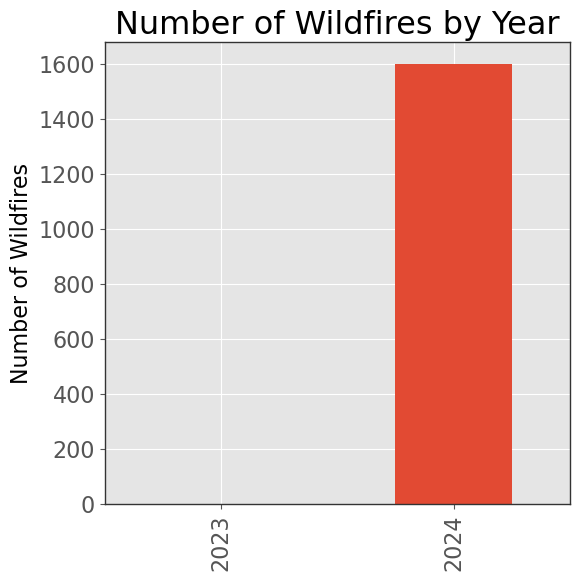

In [16]:
# Wildfires by year
wildfires_by_year = wildfire_data_cleaned['FIRE_YEAR'].value_counts().sort_index()
wildfires_by_year.plot(kind='bar', title='Number of Wildfires by Year')
plt.ylabel('Number of Wildfires')
plt.show()

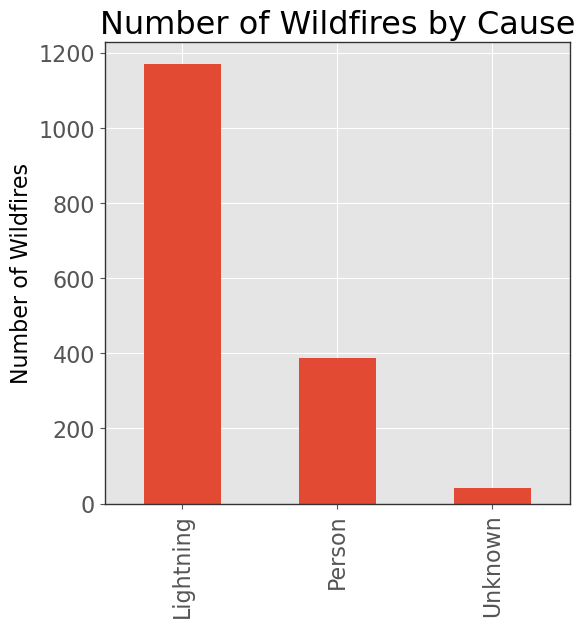

In [17]:
# Wildfires by cause
wildfires_by_cause = wildfire_data_cleaned['FIRE_CAUSE'].value_counts()
wildfires_by_cause.plot(kind='bar', title='Number of Wildfires by Cause')
plt.ylabel('Number of Wildfires')
plt.show()

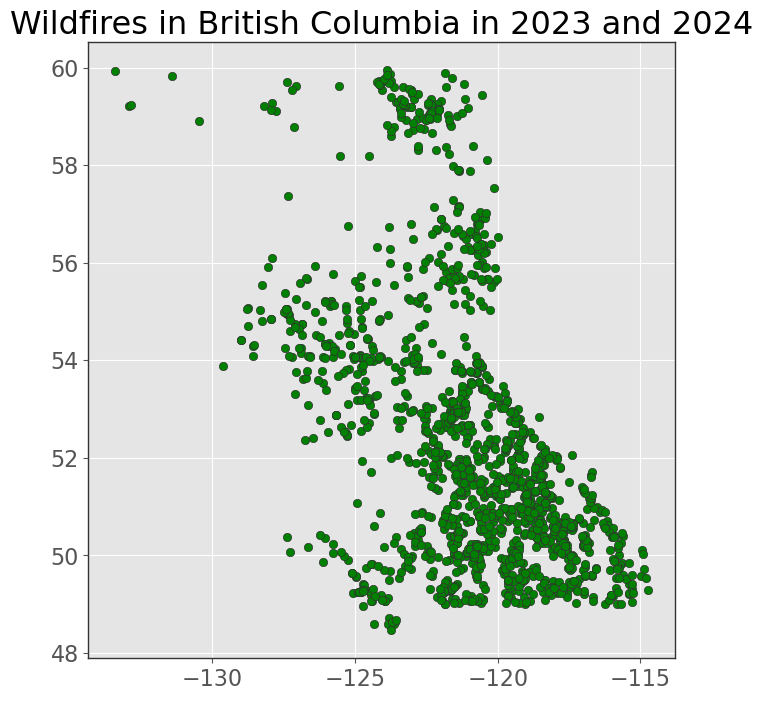

In [18]:
# Take a look at the entire forest map.
wildfire_data_cleaned.plot(edgecolor="0.2", figsize=(10, 8), color ="green")
plt.title("Wildfires in British Columbia in 2023 and 2024");

In [21]:
map_fig = px.scatter_mapbox(wildfire_data_cleaned,
                                lat="LATITUDE", lon="LONGITUDE",
                                color="FIRESTATUS",
                                hover_name="FIRE_NO",
                                hover_data={"SIZE_HA": True, "FIRESTATUS": True},
                                zoom=5,
                                height=500)

map_fig.update_layout(mapbox_style="open-street-map")
map_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

map_fig

# 3 Merging the two dataframes

## 3.1 Annotating wildfire with the forest name. 

In [24]:
# Assuming forest_data_cleaned and wildfire_data are already loaded
# Ensure both GeoDataFrames use the same CRS (coordinate reference system)
wildfire_data_cleaned = wildfire_data_cleaned.to_crs(forest_data_cleaned.crs)

# Spatial join: match wildfire points with forest polygons
wildfire_in_forest = gpd.sjoin(wildfire_data_cleaned, forest_data_cleaned, how="left", predicate="within")

# Add a column for wildfires that are not within any forest (assign 'N/A')
wildfire_in_forest['PRV_FRST_N'] = wildfire_in_forest['PRV_FRST_N'].fillna('N/A')
wildfire_in_forest

,FIRE_NO,FIRE_YEAR,RSPNS_TYPC,IGN_DATE,FR_T_DTE,FIRESTATUS,FIRE_CAUSE,GEO_DESC,LATITUDE,LONGITUDE,SIZE_HA,FIRE_URL,geometry,index_right,FEATURE_ID,PRV_FRST_D,PRV_FRST_N,OBJECTID,AREA_SQM,FEAT_LEN
0,C41494,2024,Full,20240722192118,20240723195709,Out,Lightning,E of Keith Lake,51.5341,-121.3162,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-121.31618 51.53405),292.0,2168,104,Lac La Hache,103049.0,7.462096e+09,6.874360e+05
1,N71052,2024,Full,20240717190017,20240722162310,Out,Lightning,Upper Sandy Creek,49.4354,-117.3562,0.300,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-117.35617 49.43542),7.0,2091,56,Lardeau,102816.0,1.426446e+09,3.002559e+05
2,G11274,2024,Full,20240719160000,20240720130429,Out,Lightning,Norman Lake,53.7878,-123.3749,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-123.37487 53.78777),274.0,21,92,Westlake,103031.0,2.756403e+09,6.465145e+05
3,V32102,2024,Full,20240811162738,20240815101700,Out,Person,Lovely Water Lake,49.7852,-123.2513,0.200,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-123.25127 49.78520),NaN,NaN,NaN,N/A,NaN,NaN,NaN
4,V10959,2024,Full,20240715050013,20240718131951,Out,Person,NW of Wahleach Lake,49.2762,-121.6708,1.000,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-121.67079 49.27619),NaN,NaN,NaN,N/A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,C10838,2024,Full,20240709221332,20240713161946,Out,Lightning,17.1km NW of Cariboo Lake,52.8206,-121.6312,1.100,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-121.63122 52.82055),107.0,2007,44,Cottonwood,102953.0,1.960319e+09,2.976068e+05
1596,G90894,2024,Full,20240710192131,20240714081146,Out,Lightning,Kleeto Creek,58.8159,-123.8761,0.009,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-123.87613 58.81588),33.0,2064,122,Fort Nelson,102880.0,1.874641e+10,1.173884e+06
1597,V31864,2024,NaN,20240806151716,NaN,Being Held,Lightning,Petersen Creek,50.4283,-123.0905,5.000,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-123.09047 50.42828),202.0,361,119,Soo,103061.0,5.230050e+09,1.019587e+06
1598,K41111,2024,NaN,20240718134758,NaN,Under Control,Lightning,Outlet Creek FSR,50.3258,-118.3487,21.000,https://wildfiresituation.nrs.gov.bc.ca/incide...,POINT (-118.34874 50.32577),235.0,145,88,Spallumcheen,103073.0,3.624108e+09,7.763440e+05


In [ ]:

# Count the number of wildfires per forest
wildfire_counts = wildfire_in_forest.groupby('PRV_FRST_N').size().reset_index(name='wildfire_count')

# Merge the count back to the wildfire DataFrame (optional)
wildfire_with_forest = wildfire_in_forest.merge(wildfire_counts, on='PRV_FRST_N', how='left')

# Display the resulting DataFrame
print(wildfire_with_forest[['FIRE_NO', 'PRV_FRST_N', 'wildfire_count']].head())
